In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Cargamos dataset
df_verificacion = pd.read_csv("Movimientos_limpios.csv", parse_dates=['fecha_operacion'])
display(df_verificacion.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes
1277,2024-08-05,Bizum De Debora Vega Ravelo Concepto Gasolina ...,78.00,bizum de debora vega ravelo concepto gasolina ...,ingreso,2024-08
1659,2024-03-05,"Compra Internet En Univ. Las Palma, Las Palmas...",-60.40,compra internet en univ las palma las palmas d...,gasto,2024-03
2128,2023-08-22,"Pago Movil En Hd Melenara, Telde, Tarj. :*585729",-36.73,pago movil en hd melenara telde tarj,gasto,2023-08
324,2022-06-06,"TRANSACCION CONTACTLESS EN CHIWAWA VEGUETA, PA...",-16.85,transaccion contactless en chiwawa vegueta pal...,gasto,2022-06
191,2022-02-12,"TRANSACCION CONTACTLESS EN TELDE-FLOR, TELDE, ...",-8.00,transaccion contactless en telde flor telde tarj,gasto,2022-02
296,2022-05-02,"COMPRA SpotifyES P1B3ABAD9C, Stockholm, TARJET...",-4.99,compra spotifyes pbabadc stockholm tarjeta com...,gasto,2022-05
2310,2023-05-29,"Transferencia De Evelymar Bastidas Rosario, Co...",162.00,transferencia de evelymar bastidas rosario con...,ingreso,2023-05
1747,2024-02-07,Recibo Gym Canarias Sl - Fp Telde - Las Terraz...,-30.00,recibo gym canarias sl fp telde las terraza nº...,gasto,2024-02
1948,2023-11-30,"Pago Movil En El Corte Ingles, Las Palmas, Tar...",-20.10,pago movil en el corte ingles las palmas tarj,gasto,2023-11
337,2022-06-19,"TRANSACCION CONTACTLESS EN GLOBAL SALCAI, LAS ...",-3.30,transaccion contactless en global salcai las p...,gasto,2022-06


In [3]:
# Creamos copia para no dañar base original 
df_categorias = df_verificacion.copy()

# Clasificación


In [4]:
# Creamos funcion para crear las categorias y entrenar el modelo de categorización
def clasificar_por_reglas(texto):
    texto = str(texto).lower()

    # Ingresos
    if any(p in texto for p in ['transferencia inmediata de', 'transferencia de', 'transferencia recibida', 'reintegro']):
        return 'Ingreso'
    if 'bizum de' in texto:
        return 'Ingreso'

    # Cuentas pagadas / personales
    if 'bizum a' in texto or 'transferencia a' in texto or 'traspaso' in texto:
        return 'Transferencia personal'
    
    # Facturas
    if 'recibo' in texto or 'academia' in texto or 'univ' in texto:
        return 'Facturas'

    # Préstamos
    if 'liquidacion periodica' in texto:
        return 'Préstamo'
    
    # Compras no esenciales
    compras_no_esenciales = [
        'mediamarkt', 'media markt', 'fnac','ikea', 'leroy merlin', 'decathlon',
        'zara', 'shein', 'aliexpress', 'pull&bear', 'stradivarius', 'amazon', 'playstation',
        'viveros', 'zara home', 'idea market', 'playstation', 'tabaco', 'kiwoko',
        'primor', 'agroquimica', 'druni','kiwoko'
    ]
    if any(c in texto for c in compras_no_esenciales):
        return 'Compras no esenciales'

    # Restauración
    restaurantes = [
        'la sureña', 'goiko', 'vips', 'heladeria','pizza', 'hamburguesa','heladería', 'picoteo',
        'mcdonald', 'mc donald', 'burger king', 'burguer king', 'los charcones',
        'quinta cumbre', 'bk', 'camaleon', 'tagliatella', 'bar', 'cafeteria',
        'cafetería', 'food', 'tb metropo', 'compra uber', "llaollao", "compra sumup",
        'pasteleria', 'poke','las casitas', 'gelato', 'cantina', 'nothing', 'oakberry', 'restaurante'
    ]
    if any(r in texto for r in restaurantes):
        return 'Restauración'
    
    # Veterinario
    if 'el corral' in texto:
        return 'Facturas'

    # Supermercado
    supermercado = ['mercadona', 'aldi', 'lidl', 'hiperdino', 'carrefour', 'alcampo', 'farmacia']
    if any(s in texto for s in supermercado):
        return 'Supermercado'

    # Suscripciones / ocio
    ocio = ['netflix', 'spotify', 'hbo', 'disney+', 'disney plus', 'amazon prime', 'filmin', 'nintendo', 'game pass', 'cine', 'artesiete', 'apple com']
    if any(o in texto for o in ocio):
        return 'Ocio / Suscripciones'

    
    # Transporte público
    if any(p in texto for p in ['guaguas', 'salcai', 'global']):
        return 'Transporte'

    # Transporte privado / gasolina
    gasolina = ['repsol', 'cepsa', 'bp', 'shell', 'gasolinera', 'disa', 'parking', 'motor telde', 'coche', 'rueda', 'gasolina', 'petroprix']
    if any(g in texto for g in gasolina):
        return 'Transporte'


    return 'Sin categorizar'

df_categorias["categoria"] = df_categorias["operacion_limpia"].apply(clasificar_por_reglas)
display(df_categorias[df_categorias["categoria"] == "Sin categorizar"])

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria
9,2021-09-25,"COMPRA PAGO M:VIL EN MCDONAL TRIANA, PALMAS (L...",-6.50,compra pago m vil en mcdonal triana palmas las...,gasto,2021-09,Sin categorizar
11,2021-09-26,"COMPRA PAGO M:VIL EN SPAR AMADORES, PUERTO RIC...",-4.77,compra pago m vil en spar amadores puerto rico...,gasto,2021-09,Sin categorizar
17,2021-09-28,"TRANSACCION CONTACTLESS EN HD C.C. ALISIOS, PA...",-1.99,transaccion contactless en hd c c alisios palm...,gasto,2021-09,Sin categorizar
19,2021-09-30,"COMPRA Altafit Vegueta GC, Las Palmas de, TARJ...",-9.90,compra altafit vegueta gc las palmas de tarjet...,gasto,2021-09,Sin categorizar
21,2021-10-04,"COMPRA PAGO M:VIL EN TACO BELL LAS A, LAS PALM...",-3.95,compra pago m vil en taco bell las a las palma...,gasto,2021-10,Sin categorizar
...,...,...,...,...,...,...,...
2329,2023-05-15,"Pago Movil En Minimarket La X, Las Palmas, Tar...",-0.85,pago movil en minimarket la x las palmas tarj,gasto,2023-05,Sin categorizar
2336,2023-05-11,"Pago Movil En Punto Coma, Palmas (las), Tarj. ...",-2.55,pago movil en punto coma palmas las tarj,gasto,2023-05,Sin categorizar
2342,2023-05-08,"Pago Movil En Shalom Restaura, Teror, Tarj. :*...",-7.90,pago movil en shalom restaura teror tarj,gasto,2023-05,Sin categorizar
2345,2023-05-08,"Pago Movil En Hd Melenara, Telde, Tarj. :*585729",-75.88,pago movil en hd melenara telde tarj,gasto,2023-05,Sin categorizar


# Preparación del Modelo

In [5]:
# 1 Preparar los datos seleccionando los clasificados
df_etiquetado = df_categorias[df_categorias['categoria'] != 'Sin categorizar'].copy()
display(df_etiquetado.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria
2349,2023-05-04,"Compra Internet En Repsol Waylet, Madrid, Tarj...",-28.81,compra internet en repsol waylet madrid tarj,gasto,2023-05,Transporte
1427,2024-06-11,"Pago Movil En Mercadona Las T, Hornos Del Re, ...",-19.04,pago movil en mercadona las t hornos del re tarj,gasto,2024-06,Supermercado
1367,2024-07-01,"Pago Movil En 2834 Tb Metropo, Madrid, Tarj. :...",-24.96,pago movil en tb metropo madrid tarj,gasto,2024-07,Restauración
1003,2024-12-30,"Compra Apple.com/bill, 900812703, Tarjeta 5489...",-22.99,compra apple com bill tarjeta comision,gasto,2024-12,Ocio / Suscripciones
520,2022-10-21,"PAGO MOVIL EN EST CEPSA HOYA, PALMAS (LAS), TA...",-5.19,pago movil en est cepsa hoya palmas las tarj,gasto,2022-10,Transporte
280,2022-04-26,TRANSFERENCIA DE EVELYMAR ESPERANZA BASTIDAS R...,230.00,transferencia de evelymar esperanza bastidas r...,ingreso,2022-04,Ingreso
2155,2023-08-07,Transferencia De Gomez Bastidas Oscar Alejandr...,72.00,transferencia de gomez bastidas oscar alejandr...,ingreso,2023-08,Ingreso
209,2022-02-28,"TRANSACCION CONTACTLESS EN BURGUER KING YU, MA...",-12.59,transaccion contactless en burguer king yu mas...,gasto,2022-02,Restauración
2061,2023-10-16,Bizum De Debora Vega Ravelo Concepto Gasolina,28.44,bizum de debora vega ravelo concepto gasolina,ingreso,2023-10,Ingreso
938,2025-02-10,"Pago Movil En Picoteo S. Migu, Telde, Tarj. :*...",-22.70,pago movil en picoteo s migu telde tarj,gasto,2025-02,Restauración


In [6]:
# 2 Separar texto y etiquetas
x_texto = df_etiquetado['operacion_limpia']
y_etiqueta = df_etiquetado['categoria']

In [7]:
# 2. Guardar los textos en una lista para revisarlos luego
textos_originales = x_texto.tolist()

In [8]:
#3 Vectorizar el texto con TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_vect = vectorizer.fit_transform(x_texto)

In [9]:
# 4. Entrenar el modelo
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, x_text_train, x_text_test = train_test_split(
    X_vect, y_etiqueta, textos_originales, test_size=0.2, random_state=42
)

In [10]:
# 5. Crear el arbol de clasificación
from sklearn.ensemble import RandomForestClassifier

modelo= RandomForestClassifier()
modelo.fit(x_train, y_train)

RandomForestClassifier()

# Aplicación

Accuracy 0.9842271293375394
Reporte de clasificación:
                        precision    recall  f1-score   support

 Compras no esenciales       1.00      0.90      0.95        20
              Facturas       1.00      1.00      1.00        32
               Ingreso       1.00      1.00      1.00        61
  Ocio / Suscripciones       0.96      0.96      0.96        27
              Préstamo       1.00      1.00      1.00         4
          Restauración       0.93      0.98      0.96        55
          Supermercado       1.00      0.97      0.98        31
Transferencia personal       1.00      1.00      1.00        48
            Transporte       1.00      1.00      1.00        39

              accuracy                           0.98       317
             macro avg       0.99      0.98      0.98       317
          weighted avg       0.98      0.98      0.98       317



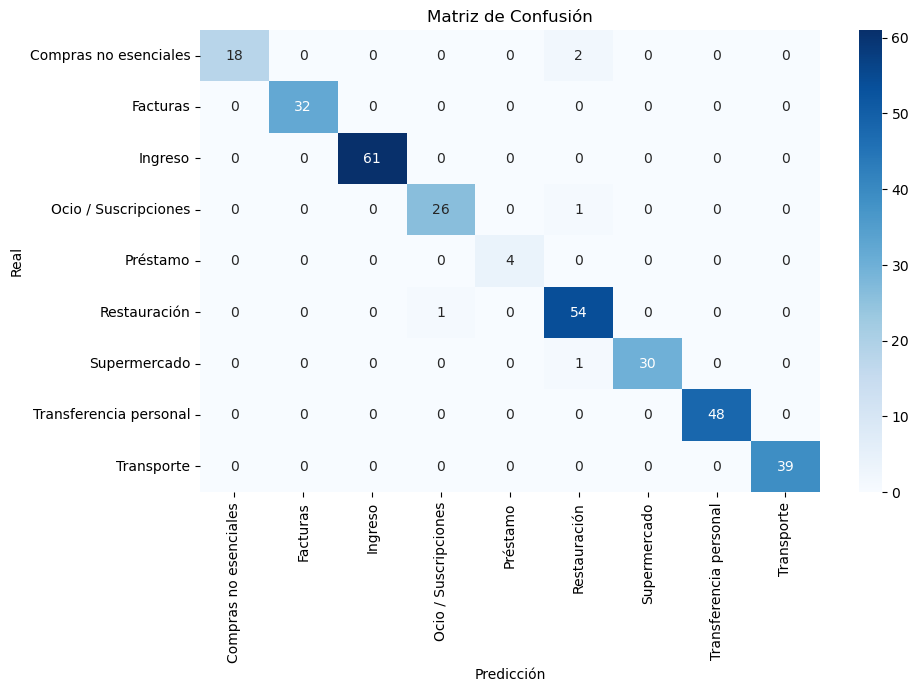

,texto,real,predicho
12,pago movil en druni s a palmas de gra tarj,Compras no esenciales,Restauración
40,pago movil en lefties zara rd telde tarj,Compras no esenciales,Restauración
150,pago movil en llaollao hornos del re tarj,Restauración,Ocio / Suscripciones
173,transaccion contactless en carrefour lpalm pal...,Supermercado,Restauración
234,pago movil en yelmo cines ali palmas las tarj,Ocio / Suscripciones,Restauración


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predice sobre el conjunto de prueba
y_pred = modelo.predict(x_test)

# Exactitud global
print('Accuracy', accuracy_score(y_test, y_pred))

# Informe por clase
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de confusión 
import seaborn as sns 

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=modelo.classes_, yticklabels=modelo.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# 7. Revisar predicciones incorrectas
errores = pd.DataFrame({
    'texto': x_text_test,
    'real': y_test.values,
    'predicho': y_pred
})
errores = errores[errores['real'] != errores['predicho']]

# Mostrar errores
display(errores.head(15))

# Categorizar los movimientos faltantes con el modelo

In [12]:
# Seleccionar solo los movimientos sin categoría
df_sin_etiquetar = df_categorias[df_categorias['categoria'] == 'Sin categorizar'].copy()


In [13]:
# Vectorizar esos nuevos textos con el vectorizer que ya tienes
x_nuevos = vectorizer.transform(df_sin_etiquetar['operacion_limpia'])

In [14]:
# predecir las categorías
df_sin_etiquetar['categoria_predicha'] = modelo.predict(x_nuevos)

In [15]:
# Ver los resultados
display(df_sin_etiquetar[['operacion_limpia', 'categoria_predicha']].sample(15))
df_sin_etiquetar.info()
df_sin_etiquetar[df_sin_etiquetar['categoria'] == 'Sin categorizar'].shape[0]

,operacion_limpia,categoria_predicha
2106,transaccion contactless en hd melenara telde tarj,Supermercado
1439,pago movil en hd melenara telde tarj,Supermercado
1483,pago movil en lacan primero d las palmas de tarj,Restauración
1288,pago movil en viveres pedro arucas tarj,Compras no esenciales
2278,compra nyx tecnotron madrid tarjeta comision,Ocio / Suscripciones
344,ingreso contra cuenta atm suc el a las,Ingreso
1564,pago movil en martin valeron telde tarj,Supermercado
453,pago movil en proxim supermer vecindario tarj,Compras no esenciales
1406,pago movil en ssp telde tarj,Supermercado
272,transaccion contactless en natural kitchen las...,Restauración


<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 9 to 2361
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha_operacion     781 non-null    datetime64[ns]
 1   operacion           781 non-null    object        
 2   importe             781 non-null    float64       
 3   operacion_limpia    781 non-null    object        
 4   tipo                781 non-null    object        
 5   año_mes             781 non-null    object        
 6   categoria           781 non-null    object        
 7   categoria_predicha  781 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 54.9+ KB


781

In [16]:
# 4. Actualizar el DataFrame original usando índices
df_categorias.loc[df_sin_etiquetar.index, 'categoria'] = df_sin_etiquetar['categoria_predicha'].values

# 5. Añadir columna origen
df_categorias['origen'] = 'manual'
df_categorias.loc[df_sin_etiquetar.index, 'origen'] = 'modelo'
display(df_categorias.sample(15))
df_categorias[df_categorias['categoria'] == 'Sin categorizar'].shape[0]

df_categorias.info()

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
1593,2024-04-01,"Pago Movil En Bazar Valsequil, Valsequillo, Ta...",-5.80,pago movil en bazar valsequil valsequillo tarj,gasto,2024-04,Supermercado,modelo
1140,2024-10-30,Bizum A Favor De Debora Vega Ravelo Concepto: ...,-26.00,bizum a favor de debora vega ravelo concepto c...,gasto,2024-10,Transferencia personal,manual
752,2023-03-17,BIZUM A FAVOR DE JUAN JOSE RODRIGUEZ ALVAREZ C...,-10.00,bizum a favor de juan jose rodriguez alvarez c...,gasto,2023-03,Transferencia personal,manual
2182,2023-07-31,"Pago Movil En Bar Cafeteria T, Valsequillo (, ...",-2.80,pago movil en bar cafeteria t valsequillo tarj,gasto,2023-07,Restauración,manual
1921,2023-12-04,"Compra Sumup *kraken, Las Palmas, Tarjeta 5489...",-3.00,compra sumup kraken las palmas tarjeta comision,gasto,2023-12,Restauración,manual
359,2022-07-13,"TRANSACCION CONTACTLESS EN TOOLMAN SERVICE, LA...",-53.50,transaccion contactless en toolman service las...,gasto,2022-07,Restauración,modelo
1626,2024-03-21,"Pago Movil En Mcdonalds Telde, Telde, Tarj. :*...",-16.61,pago movil en mcdonalds telde telde tarj,gasto,2024-03,Restauración,manual
566,2022-11-16,"COMPRA Excelfull-Plan Excel, Nederland, TARJET...",-49.00,compra excelfull plan excel nederland tarjeta ...,gasto,2022-11,Ocio / Suscripciones,modelo
626,2022-12-22,"PAGO MOVIL EN MCDONALDS TELDE, TELDE, TARJ. :*...",-11.00,pago movil en mcdonalds telde telde tarj,gasto,2022-12,Restauración,manual
63,2021-11-19,"TRANSACCION CONTACTLESS EN LAS CASITAS EMP, LA...",-1.20,transaccion contactless en las casitas emp las...,gasto,2021-11,Restauración,manual


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha_operacion   2362 non-null   datetime64[ns]
 1   operacion         2362 non-null   object        
 2   importe           2362 non-null   float64       
 3   operacion_limpia  2362 non-null   object        
 4   tipo              2362 non-null   object        
 5   año_mes           2362 non-null   object        
 6   categoria         2362 non-null   object        
 7   origen            2362 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 147.8+ KB


# Limpieza de los datos por categorías

In [ ]:
df_categorizado= df_categorias.copy()
display(df_categorizado.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
434,2022-08-18,"TRANSACCION CONTACTLESS EN ELECTRO TV KAIR, LA...",-12.60,transaccion contactless en electro tv kair las...,gasto,2022-08,Restauración,modelo
582,2022-12-02,TRANSFERENCIA DE EVELYMAR ESPERANZA BASTIDAS R...,35.00,transferencia de evelymar esperanza bastidas r...,ingreso,2022-12,Ingreso,manual
1376,2024-06-26,"Compra Munchener Natursaft, Muenchen, Tarjeta ...",-7.20,compra munchener natursaft muenchen tarjeta co...,gasto,2024-06,Ocio / Suscripciones,modelo
1063,2024-12-05,"Compra Www.amazon.* 2d79s1hv5, Luxembourg, Tar...",-55.58,compra www amazon dshv luxembourg tarjeta comi...,gasto,2024-12,Compras no esenciales,manual
1335,2024-07-08,"Pago Movil En Llao Llao Las C, Palmas (las), T...",-8.80,pago movil en llao llao las c palmas las tarj,gasto,2024-07,Compras no esenciales,modelo
1223,2024-08-22,"Compra Apple.com/bill, 900812703, Tarjeta 5489...",-22.99,compra apple com bill tarjeta comision,gasto,2024-08,Ocio / Suscripciones,manual
1324,2024-07-12,"Pago Movil En Hde C.c. Bahia, Palmas De Gra, T...",-4.25,pago movil en hde c c bahia palmas de gra tarj,gasto,2024-07,Restauración,modelo
759,2023-03-19,BIZUM DE JUAN MIGUEL VIERA RODRIGUEZ CONCEPTO ...,2.00,bizum de juan miguel viera rodriguez concepto ...,ingreso,2023-03,Ingreso,manual
535,2022-10-31,"PAGO MOVIL EN SUPERMERCDO LOP, VALSEQUILLO (, ...",-3.61,pago movil en supermercdo lop valsequillo tarj,gasto,2022-10,Supermercado,modelo
799,2023-04-20,RECIBO VODAFONE Factura: YJ23-000620633/ N: RE...,-33.43,recibo vodafone factura yj n recibo bbfhdqw re...,gasto,2023-04,Facturas,manual


<Axes: xlabel='categoria'>

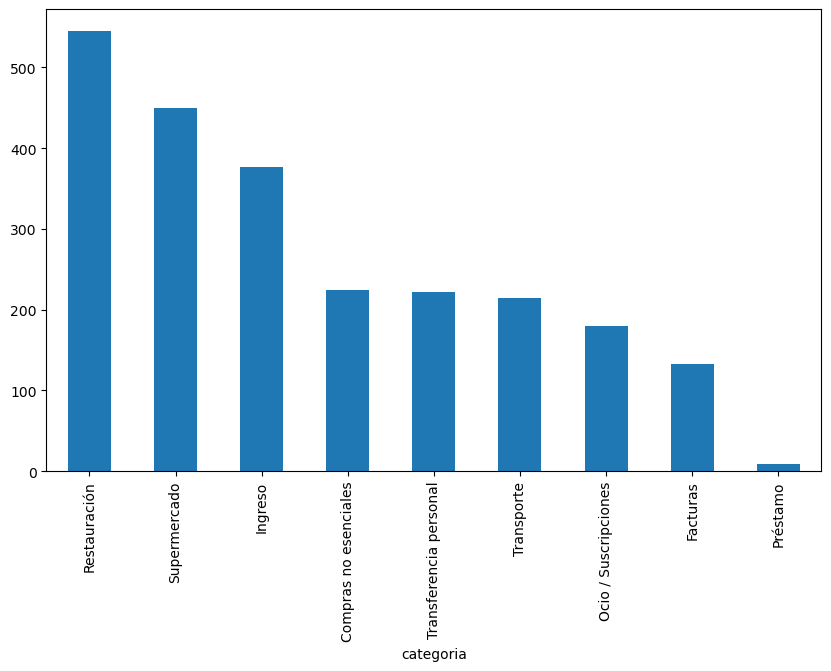

In [19]:
# Ubicamos por categoria
df_categorizado['categoria'].value_counts().plot(kind='bar', figsize=(10,6))

In [20]:
categoria = df_categorizado['categoria'].value_counts()
display(categoria)

categoria
Restauración              545
Supermercado              450
Ingreso                   377
Compras no esenciales     224
Transferencia personal    222
Transporte                214
Ocio / Suscripciones      180
Facturas                  133
Préstamo                    9
Name: count, dtype: int64

In [21]:
#  Pasamos los gastos a valores positivos
df_categorizado['importe'] = df_categorizado['importe'].abs()

In [22]:
#Analizamos los valores de préstamo
prestamo = df_categorizado[df_categorizado['categoria'] == 'Préstamo']
display(prestamo)

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
373,2022-07-17,LIQUIDACION DEL CONTRATO 0003735 300,0.03,liquidacion del contrato,gasto,2022-07,Préstamo,modelo
862,2025-04-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-04,Préstamo,manual
912,2025-02-28,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-02,Préstamo,manual
951,2025-01-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-01,Préstamo,manual
1001,2024-12-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
1077,2024-12-02,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
1132,2024-10-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1197,2024-10-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1471,2024-05-20,Liquidacion Del Contrato 0003735 300,0.02,liquidacion del contrato,gasto,2024-05,Préstamo,modelo


In [23]:
resumen_categorias = df_categorizado.groupby('categoria')['importe'].agg(['count', 'sum', 'mean', 'min', 'max']).sort_values('sum', ascending=False)
display(resumen_categorias)

,count,sum,mean,min,max
categoria,,,,,
Ingreso,377,59543.16,157.939416,0.01,1836.67
Transferencia personal,222,13682.96,61.634955,0.02,600.00
Supermercado,450,9918.43,22.040956,0.35,130.00
Facturas,133,9520.82,71.585113,1.00,342.35
Restauración,545,8883.50,16.300000,0.20,874.00
Compras no esenciales,224,6432.18,28.715089,0.20,797.03
Transporte,214,4626.58,21.619533,0.01,149.82
Ocio / Suscripciones,180,3858.13,21.434056,1.00,1430.05
Préstamo,9,1380.38,153.375556,0.02,197.19


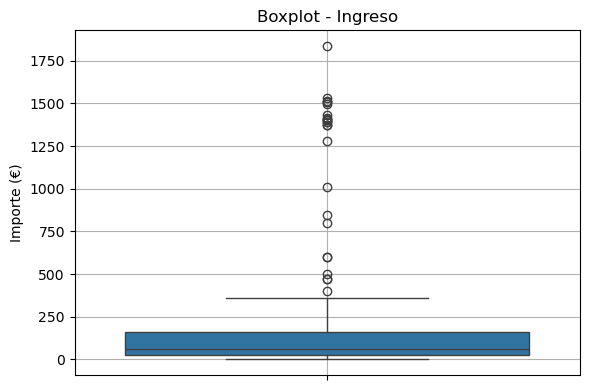

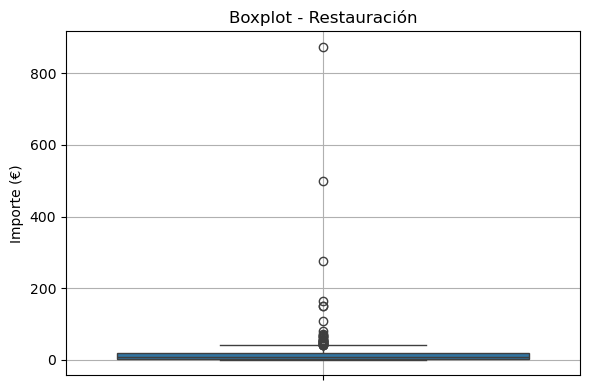

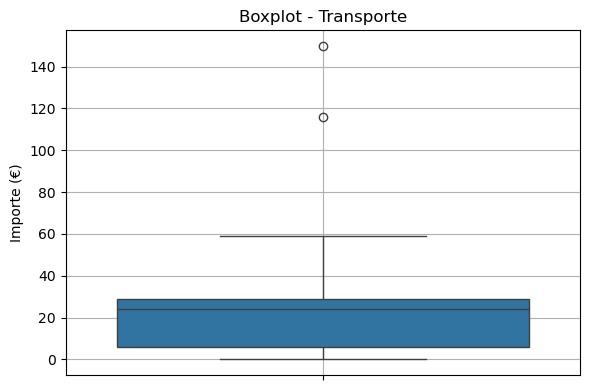

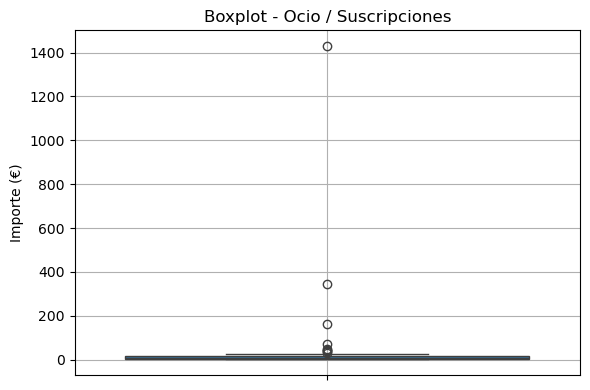

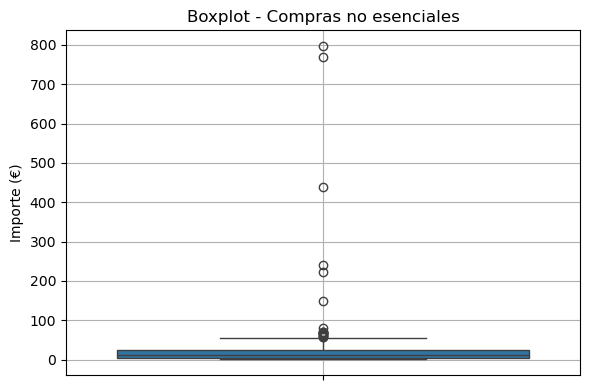

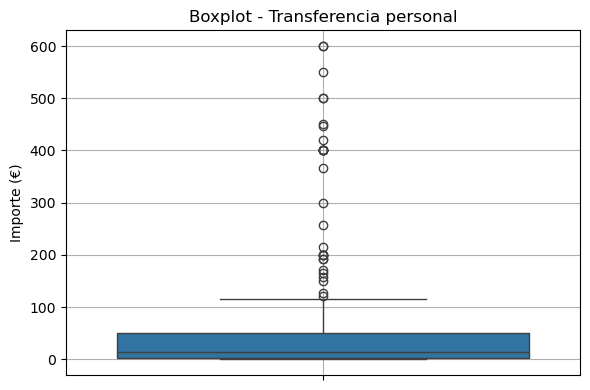

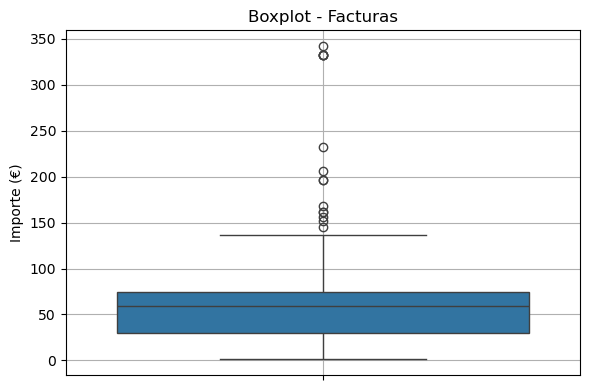

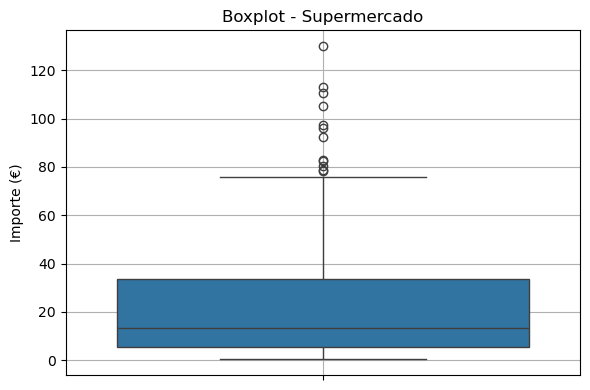

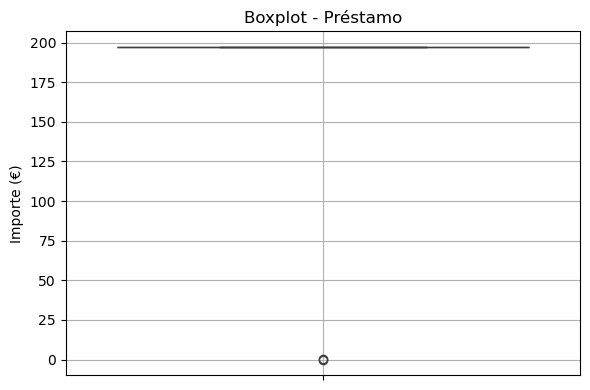

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:
def mover_outliers_a_gastos_extra(df):
    df = df.copy()

    for cat in df['categoria'].unique():
        datos = df[df['categoria'] == cat]['importe']
        q1, q3 = datos.quantile([0.25, 0.975])
        iqr = q3 - q1
        bajo = q1 - 1.5 * iqr
        alto = q3 + 1.5 * iqr

        es_outlier = (df['categoria'] == cat) & ((df['importe'] < bajo) | (df['importe'] > alto))
        df.loc[es_outlier, 'categoria'] = 'Gastos extraordinarios'

    return df


In [26]:
df_categorizado = mover_outliers_a_gastos_extra(df_categorizado)
df_categorizado['categoria'].value_counts()


categoria
Restauración              539
Supermercado              450
Ingreso                   377
Transferencia personal    222
Compras no esenciales     221
Transporte                212
Ocio / Suscripciones      177
Facturas                  133
Gastos extraordinarios     16
Préstamo                    7
Name: count, dtype: int64

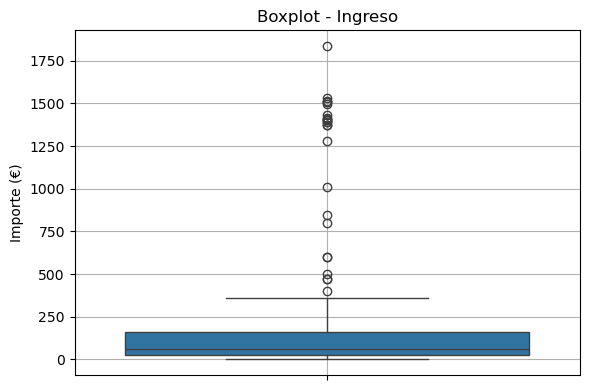

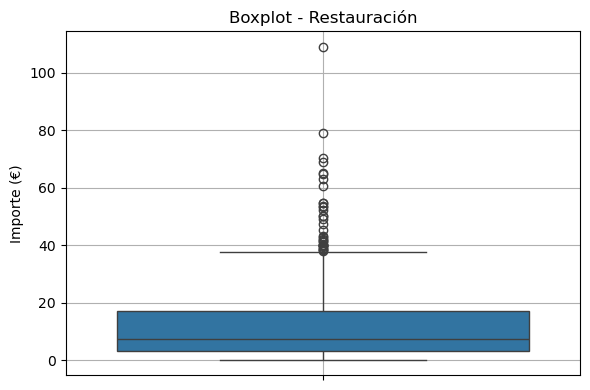

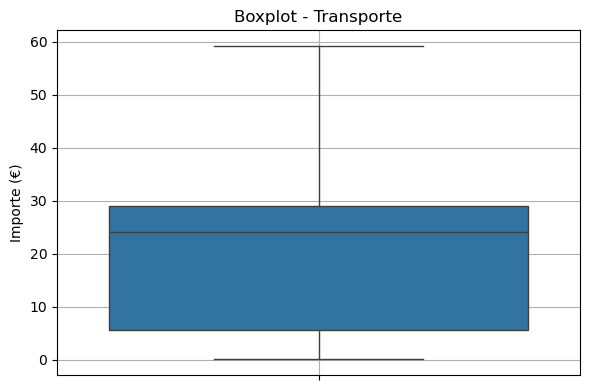

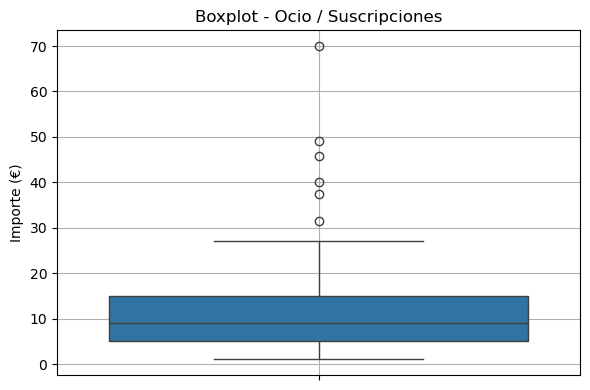

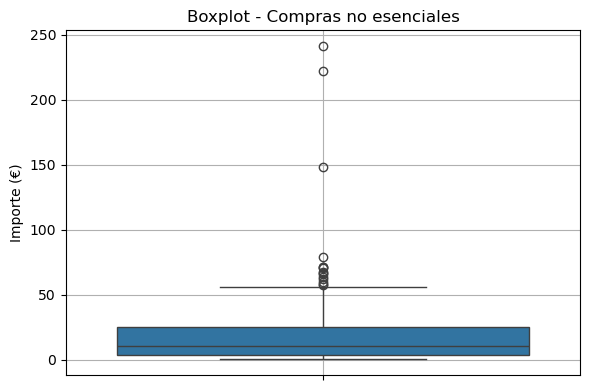

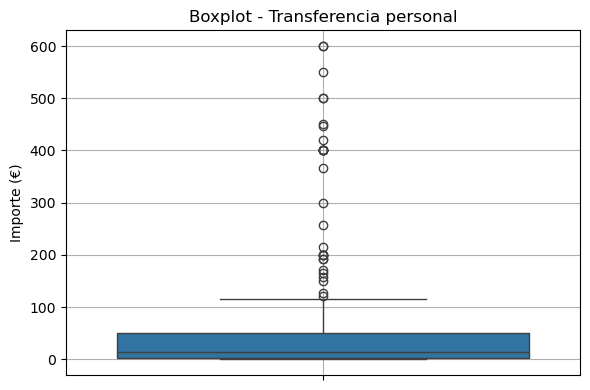

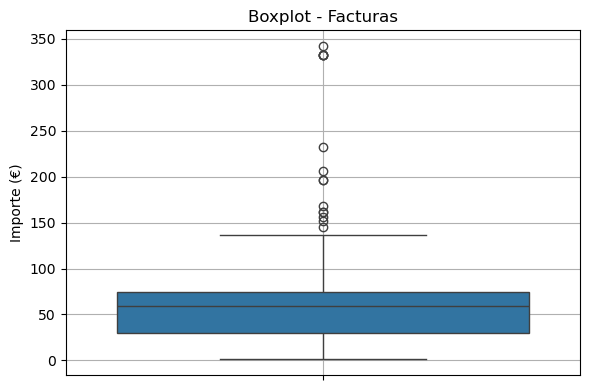

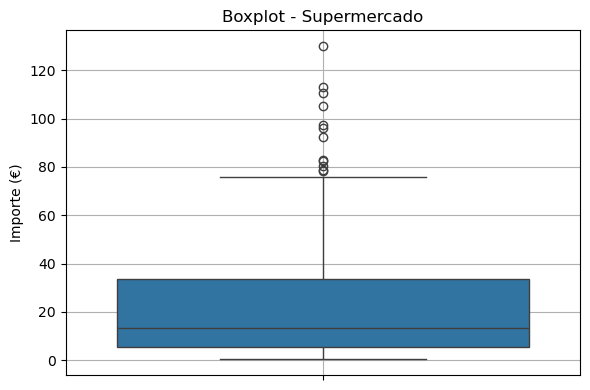

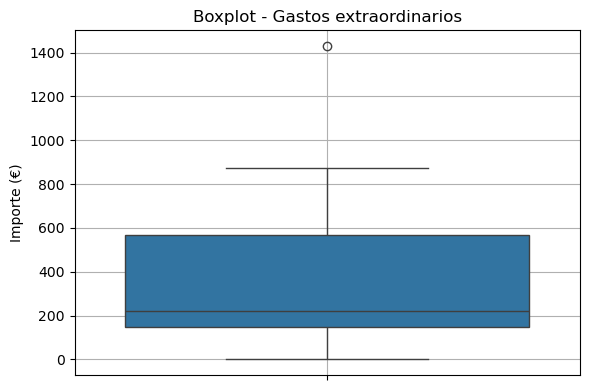

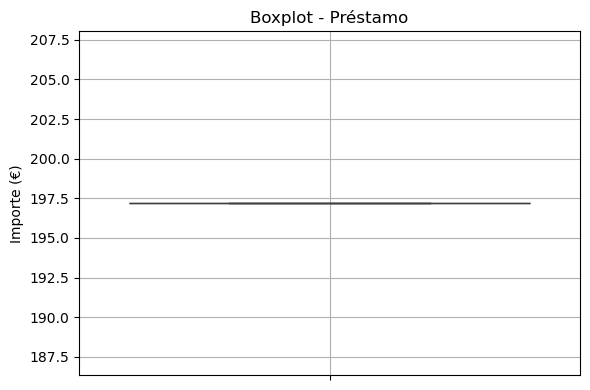

In [27]:
# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [28]:
# Guardar el CSV
df_categorizado.to_csv("Movimientos_categorizados.csv", index=False)